In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import layoutparser as lp
import os
os.chdir('..')

In [10]:
annotated = {}
output = Path('outputs_kappa')
for i in output.glob('*_data.csv'):
    l = i.stem.split('.')
    arxiv_id = l[0]+'.'+l[1][:-2]
    df = pd.read_csv(i, sep='\t')
    if 'label' in df and len(df['label'].value_counts()) > 3: # in case of parsing error but compiled successful
        annotated[arxiv_id] = i

collect = {}
docbank = Path('DocBank_500K_txt')
for i in docbank.glob('*.txt'):
    arxiv_id = str(i.stem).split('_')[1][:-3]
    page_num = int(str(i.stem).split('_')[-1]) + 1
    if arxiv_id in annotated:
        df = pd.read_csv(i, sep='\t', names=['token', 'x0', 'y0', 'x1', 'y1', 'r', 'g', 'b', 'fontname', 'label'])
        if arxiv_id in collect:
            collect[arxiv_id].append((page_num, df))
        else:
            collect[arxiv_id] = [(page_num, df)]
print(len(collect.keys()))
pred = []
gold = []
for k, v in collect.items():
    rainbow = pd.read_csv(annotated[k], sep='\t')
    for page, df in v:
        filtered = rainbow[rainbow['page']==page]
        layout = {}
        layout_counter = {}
        for idx, row in df.iterrows():
            if row['token'] in layout:
                layout[row['token']].append(row['label'])
            else:
                layout[row['token']] = []
                layout[row['token']].append(row['label'])
        for idx, row in filtered.iterrows():
            label = row['label']
            if isinstance(label, str):
                label = label.lower()
            else:
                label = 'none'
            if row['token'] in layout:
                pred.append(label)
                count = layout_counter.get(row['token'], 0)
                if count < len(layout[row['token']]):
                    gold.append(layout[row['token']][count])
                else:
                    gold.append(layout[row['token']][0])
                layout_counter[row['token']] = count + 1

61


## Calculate consistency scores, and Precision, Recall, F1 scores for each category.

In [12]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(pred+gold)

import sklearn.metrics
sklearn.metrics.cohen_kappa_score(le.transform(gold), le.transform(pred))

0.325438400838737

In [5]:
le.classes_

array(['abstract', 'author', 'caption', 'date', 'equation', 'figure',
       'footer', 'list', 'none', 'paragraph', 'reference', 'section',
       'table', 'title'], dtype='<U9')

In [13]:
sklearn.metrics.precision_score(le.transform(gold), le.transform(pred), average=None)

/home/duan/texcompile/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.97790773, 0.50276243, 0.46760459, 0.        , 0.19573009,
       0.        , 0.20290909, 0.44628099, 0.        , 0.93792707,
       0.83557237, 0.51197053, 0.88068756, 0.34297521])

In [14]:
sklearn.metrics.recall_score(le.transform(gold), le.transform(pred), average=None)

/home/duan/texcompile/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.81971678, 0.55151515, 0.38517841, 0.        , 0.90165104,
       0.        , 0.26123596, 0.17624021, 0.        , 0.60804824,
       0.97183099, 0.37771739, 0.79398359, 0.53205128])

In [15]:
sklearn.metrics.f1_score(le.transform(gold), le.transform(pred), average=None)

array([0.89185185, 0.52601156, 0.42240803, 0.        , 0.32163892,
       0.        , 0.2284077 , 0.25269069, 0.        , 0.73779303,
       0.89856547, 0.43471462, 0.83509108, 0.41708543])

## Verify the alignment of DocBank and our framework

First randomly select a pair from the labeled data

In [42]:
import random
k, v = collect.popitem()
page, df = random.choice(v)
rainbow = pd.read_csv(annotated[k], sep='\t')
filtered = rainbow[rainbow['page']==page]


Visualization of DocBank's annotations

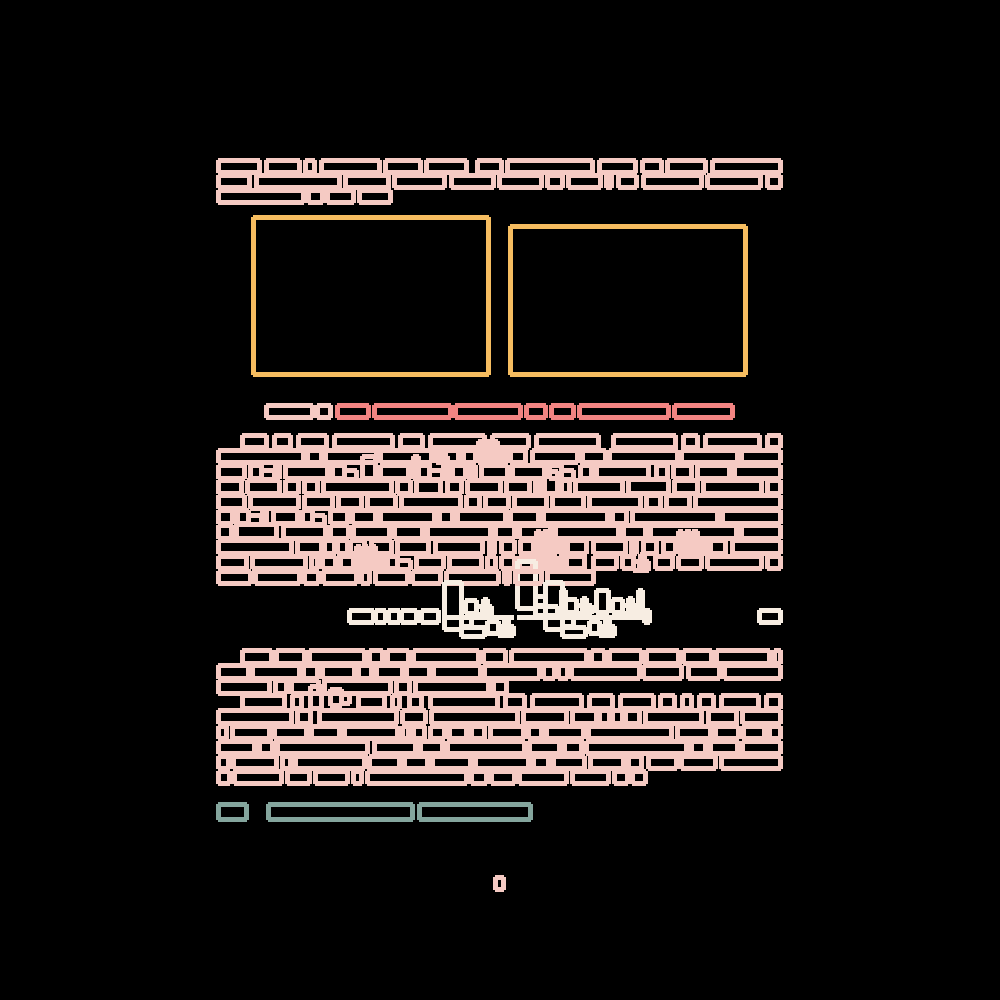

In [43]:
layout = lp.Layout()
for idx, row in df.iterrows():
    #print(row)
    layout.append(
        lp.TextBlock(
            block = lp.Rectangle(row['x0'], row['y0'], row['x1'], row['y1']),
            type  = row['label'],
        )
    )
image = np.zeros([1000,1000,3], np.uint8)
viz = lp.draw_box(image, layout)
viz

Visualization of LaTeX Rainbow's annotations

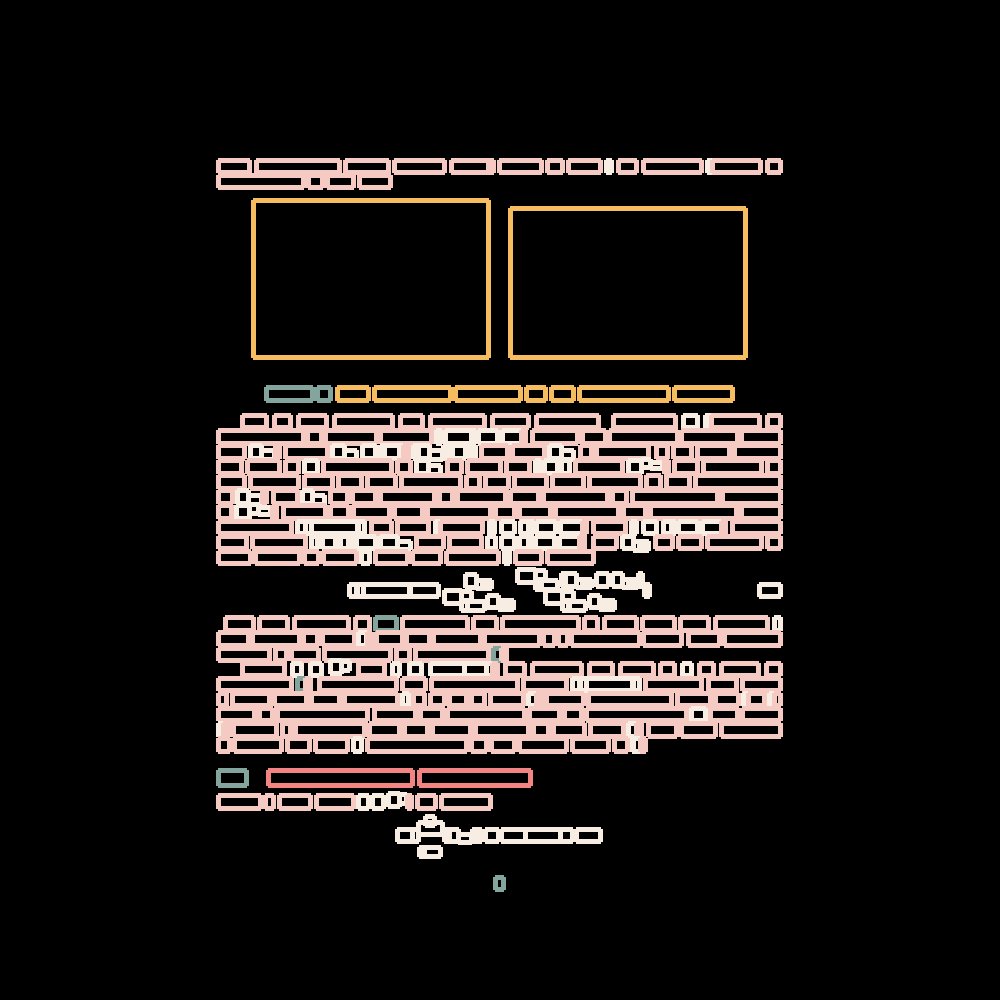

In [44]:
import json
layout2 = lp.Layout()
for i, row in filtered.iterrows():
    if row['label'] == 'Figure':
        height, width = [792, 612]
    else:
        height, width = json.loads(row['flags'])
    f_x0 = min(1000, max(0, int(row['x0'] / width * 1000)))
    f_y0 = min(1000, max(0, int(row['y0'] / height * 1000)))
    f_x1 = min(1000, max(0, int(row['x1'] / width * 1000)))
    f_y1 = min(1000, max(0, int(row['y1'] / height * 1000)))
    word_bbox = tuple([f_x0, f_y0, f_x1, f_y1])
    
    # plot annotation
    x0, y0, x1, y1 = word_bbox
    #x0, y0, x1, y1 = int(x0 * width / 1000), int(y0 * height / 1000), int(x1 * width / 1000), int(
    #    y1 * height / 1000)
    label = row['label']
    if isinstance(label, str):
        label = label.lower()
    else:
        label = 'none'
    layout2.append(
        lp.TextBlock(
            block = lp.Rectangle(x0, y0, x1, y1),
            type  = label,
        )
    )

image2 = np.zeros([1000,1000,3], np.uint8)
viz2 = lp.draw_box(image2, layout2)
viz2

Compare it to what it originally looked like in arXiv, we can see a slight displacement of DocBank's labeling.

In [45]:
k, page

('1807.08825', 3)

--2023-09-08 13:10:40--  https://arxiv.org/e-print/1807.08825
Resolving arxiv.org (arxiv.org)... 128.84.21.199
Connecting to arxiv.org (arxiv.org)|128.84.21.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 762904 (745K) [application/x-eprint-tar]
Saving to: ‘doc/1807.08825.tar.gz’

doc/1807.08825.tar. 100%[===================>] 745,02K  1,31MB/s    in 0,6s    

2023-09-08 13:10:41 (1,31 MB/s) - ‘doc/1807.08825.tar.gz’ saved [762904/762904]



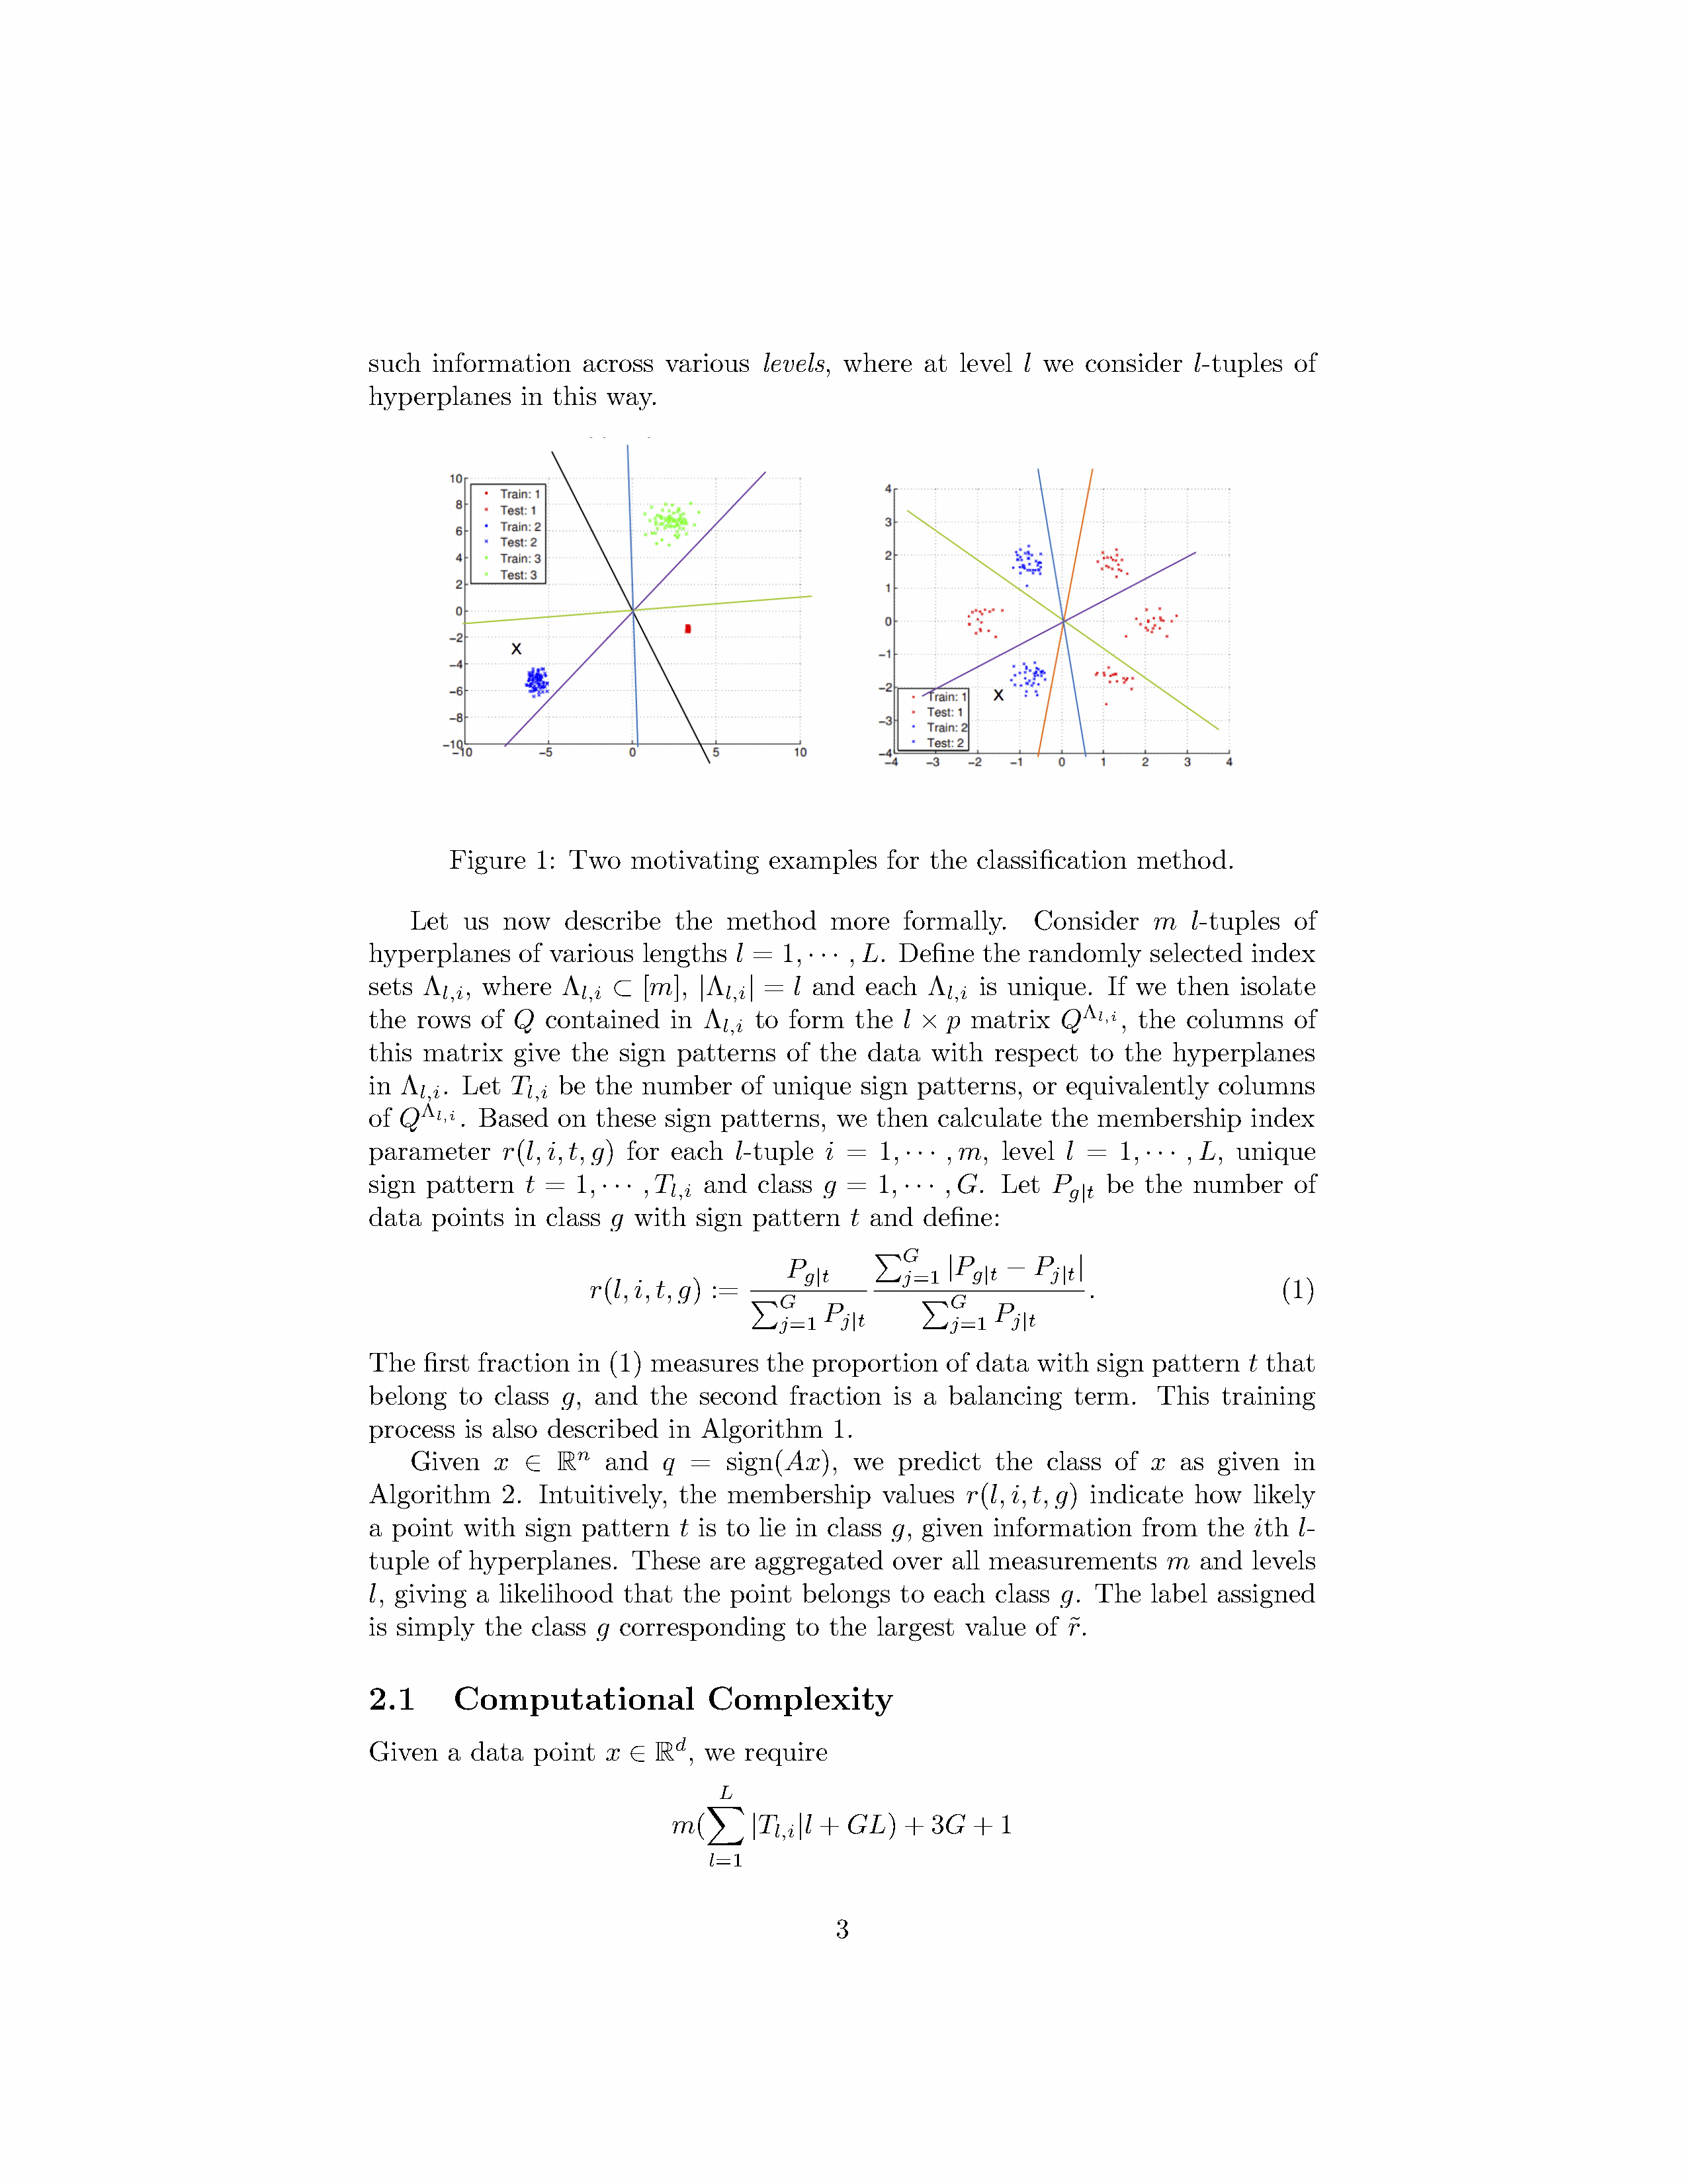

In [46]:
!wget -O doc/1807.08825.tar.gz https://arxiv.org/e-print/1807.08825 --user-agent "Name <email>"
from texcompile.client import compile_pdf_return_bytes
import docker
import tarfile
import pdfplumber
from memory_tempfile import MemoryTempfile
from utils.utils import (find_free_port, find_latex_file, postprocess_latex,
                  preprocess_latex, tup2str)
client = docker.from_env()
port = find_free_port()
tempfile = MemoryTempfile()
container = client.containers.run(
    image='tex-compilation-service',
    detach=True,
    ports={'80/tcp':port},
    tmpfs={'/tmpfs':''},
    remove=True,
)
with tempfile.TemporaryDirectory() as td:
    with tarfile.open('doc/1807.08825.tar.gz' ,'r:gz') as tar:
        tar.extractall(td)
        preprocess_latex(td)

    basename, pdf_bytes = compile_pdf_return_bytes(
        sources_dir=td
    )

with pdfplumber.open(pdf_bytes) as doc:
    p0 = doc.pages[2]
    im_origin = p0.to_image(resolution=300)

container.stop()
im_origin

This may because the authors changed their source code, after the release of DocBank. 
Unfortunately we don't have access to the version of the code that was available at the time of DocBank's annotation.